### Часть 1. Снова логистическая регрессия

Рассмотрим задачу минимизации эмпирического риска (да-да, machine learning):
\begin{equation}
\min_{w \in \mathcal{X} \subset \mathbb{R}^d} \frac{1}{n} \sum\limits_{i=1}^n \ell (g(w, x_i), y_i),
\end{equation}
где $\ell: \mathbb{R} \times \mathbb{R} \to \mathbb{R}$ - функция потерь, $g : \mathbb{R}^d \times \mathbb{R}^x \to \mathbb{R}$ - модель, $w$ - параметры модели, $\{x_i, y_i\}_{i=1}^n$ - выборка данных из векторов признаков $x_i \in \mathbb{R}^x$ и меток $y_i \in \mathbb{R}$.

Используем линейную модель $g(w, x) = w^T x$ и логистическую/сигмоидную функцию потерь: $\ell(z,y) = \ln (1 + \exp(-yz))$ (__Важно: $y$ должен принимать значения $-1$ или $1$__). Полученная задача называется задачей логистической регрессии.

В качестве множества $\mathcal{X}$ возьмем $\ell_1$-шар с центром в 0 и радиуса $R$ (параметр, которые можно менять): $\mathcal{X} =\{x \in \mathbb{R}^d \mid \| x \|_1 \leq R \}$.

__Отличия от прошлого домашнего задания:__ убрали регуляризатор, добавили множество $\mathcal{X}$.

Градиент для нашей целевой функции:
$$
\frac{1}{n} \sum_{i=1}^n \frac{-y_i x_i}{1 + \exp(y_i w^Tx_i)}.
$$
В качестве константы Липшица нашей целевой функции можно брать $L = \frac{1}{4n} \sum\limits_{i=1}^n \| x_i \|^2_2$.

К заданию приложен датасет _mushrooms_. С помощью следующего кода сформируйте матрицу $X$ и вектор $y$, в которой и будет храниться выборка $\{x_i, y_i\}_{i=1}^n$:

In [ ]:
#ЭТА ЯЧЕЙКА НУЖНА, ЧТОБЫ ВСЕ ИМПОРТИРОВАТЬ!!!
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from jax import grad
import jax.numpy as jnp
import torch as tr
import time
from random import randint
import sklearn as skl
plt.style.use('seaborn-darkgrid')

<ipython-input-1-8ada70582332>:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [ ]:
dataset = "mushrooms.txt"
#файл должен лежать в той же деректории, что и notebook

In [ ]:
from sklearn.datasets import load_svmlight_file
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

Поменяем вектор $y$, чтобы $y_i$ принимали значения $-1$ и $1$. Вы также можете сделать дополнительную предобработку данных (приемами из машинного обучения), но это никак дополнительно не оценивается.

In [ ]:
y = 2 * y - 3

Разделим данные на две части: обучающую и тестовую.

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Для обучающей части $X_{train}$, $y_{train}$ оцените константу $L$. Реализуйте в коде подсчет значения и градиента нашей целевой функции ($X$, $y$ лучше подавать в качестве параметра, чтобы была возможность их менять, а не только подставлять фиксированные $X_{train}$, $y_{train}$). Можно использовать как библиотеку ``numpy``, так и библиотеки ``autograd``, ``pytorch``, ``jax``.

Для начала оценим константу Липшеца для $X_{train}, y_{train}$. Мы получили в выводах, что $L \geq \frac{1}{4n}||X_{train}||_2^2 + λ.$ Если $λ = \frac{L}{1000}$, то $\frac{999L}{1000} = \frac{1}{4n}||X_{train}||_F^2 => L = \frac{1000}{3996n}||X_{train}||_2^2$.

In [ ]:
import torch as tr
X_train_tr = tr.from_numpy(X_train).to(tr.float64)
X_test_tr = tr.from_numpy(X_test).to(tr.float64)
y_train_tr = tr.from_numpy(y_train).to(tr.float64)
y_test_tr = tr.from_numpy(y_test).to(tr.float64)
def f(w, X, y):  #Определяем функцию
  tmp = tr.mean(tr.log((1 + tr.exp(-y * (X @ w)))))
  return tmp
def nabla_f(w, X, y): #Определеляем градиент
  return tr.func.grad(f)(w, X, y)

__Задача. (всего 33 балла)__ Так как мы теперь решаем задачу оптимизации на шаре, необходимы методы, учитывающие это.

__а). (3 балла)__ Для $\ell_1$-шара с центром в 0 и радиуса $R$ найдите выражение для решения задачи линейной оптимизации при заданном векторе $g \in \mathbb{R}^d$:
$$
s^* = \arg \min_{s \in \mathcal{X}} \langle s, g \rangle.
$$

Формально обоснуйте свой ответ, например, можно (необязательно именно так) использовать условия ККТ.

__а). (3 балла)__ Реализуйте отдельно решение задачи линейной оптимизации из предыдущего пункта (радиус шара $R$ лучше передавать в качестве параметра). Реализуйте метод Франк-Вульфа для нашей задачи. Для заданий далее может понадобиться возможность замерять время работы метода. Советуем также следующим образом брать шаг в алгоритме: если итерации нумеруются с 0, то $\gamma = \frac{2}{k+3}$, если итерации нумеруются с 1, то $\gamma = \frac{2}{k+2}$.

Как было сказано на лекциях, решением будет являеться $s^* = -sign(g_i)R \cdot e_i, где i = argmax_j(|g_j|)$.<br>
Для доказательства пойдем от противного, предположим, что $∃s_1 → \displaystyle{\sum_{j=1}^d |s_{1_j}|} = R$ и при этом $s_1^Tg < (s^*)^Tg$. Тогда $(s^*)^Tg = -sign(g_i)R⟨g, e_i⟩ = -sign(g_i)R \cdot g_i = -|g_i|R$.<br>
Теперь рассмотрим $s_1^Tg = \displaystyle{\sum_{j=1}^d s_{1_j}g_j \geq -\sum_{j=1}^d |s_{1_j}| ⋅ |g_j| \geq -|g_i|\sum_{j=1}^d|s_{1_j}| = -|g_i|R}$.<br>
Мы получили что $s_1^Tg \geq (s^*)^Tg$ - противоречит с предположением. А значит $s^*$ и будет являться решением этой задачи.

In [ ]:
def criteria(xk, X, y, R): #Наш критерий
  grad = tr.func.grad(f)(xk, X, y).data
  ind = tr.argmax(tr.abs(grad))
  e = []
  for i in range(len(xk)):
    if (tr.tensor(i) == ind): e.append(R)
    else: e.append(0)
  e = tr.tensor(e).to(tr.float64)
  second = -tr.sign(grad[ind]) * e
  return grad @ (xk - second)
def Franc_Wulf(f, nabla_f, x_0, X, y, X_pred, R, K = 10**3):
  difs = []
  times = []
  time1 = time.time()
  for k in range(K):
    grad = tr.func.grad(f)(x_0, X, y).data
    ind = tr.argmax(tr.abs(grad))
    e = []
    for i in range(len(x_0)):
      if (tr.tensor(i) == ind): e.append(R)
      else: e.append(0)
    e = tr.tensor(e).to(tr.float64)
    s = -tr.sign(grad[ind]) * e
    gamma_k = 2 / (k + 3)
    x_new = (1 - gamma_k) * x_0 + gamma_k * s
    difs.append(criteria(x_0, X, y, R).detach().to().numpy())
    x_0 = x_new
    times.append(time.time() - time1)
  preds = x_0 @ X_pred.T
  return (x_0, difs, preds, times)

__б). (5 баллов)__ Решите задачу оптимизации на обучающей выборке с помощью реализованного методов. Возьмите $R = 5$ и стратовую точку в $0$. В качестве критерия используйте следующее выражение:
$$
\text{gap}(w^k) = \max_{y \in \mathcal{X}} \langle \nabla f(w^k), w^k - y \rangle,
$$
или усредненную версию $\frac{1}{k} \sum_{i=1}^k \text{gap}(w^i)$. Такой критерий используем, так как не знаем значение $f^*$ и не можем гарантировать, что $\nabla f(w^*) = 0$. Но можно показать, что $\text{gap}(w^k) \geq f(w^k) - f^*$, а также доаказать сходимость метода Франк-Вульфа по такому критерию, а значит сходимость по $\text{gap}(w^k)$ и дает хорошее понимание о поведении $f(w^k) - f^*$.

Постройте график сходимости: значение критерия сходимости от номера итерации.

Во-первых, заметим, что $\text{gap}(w^k) = \max_{y \in \mathcal{X}} \langle \nabla f(w^k), w^k - y \rangle$ эквивалетно тому, что $⟨∇f(w^k), w^k⟩ - ⟨∇f(w^k), y⟩ = 0$. Первое - константа, а значит, чтобы максимизировать это выражение нам надо минимизировать второе, а такую задачу мы решали немного выше, ответ на нее получается $y^* = -R * sign(∇f(w^k)_i)e_i$, где $i = argmax_j(|∇f(w^k)_j|)$.

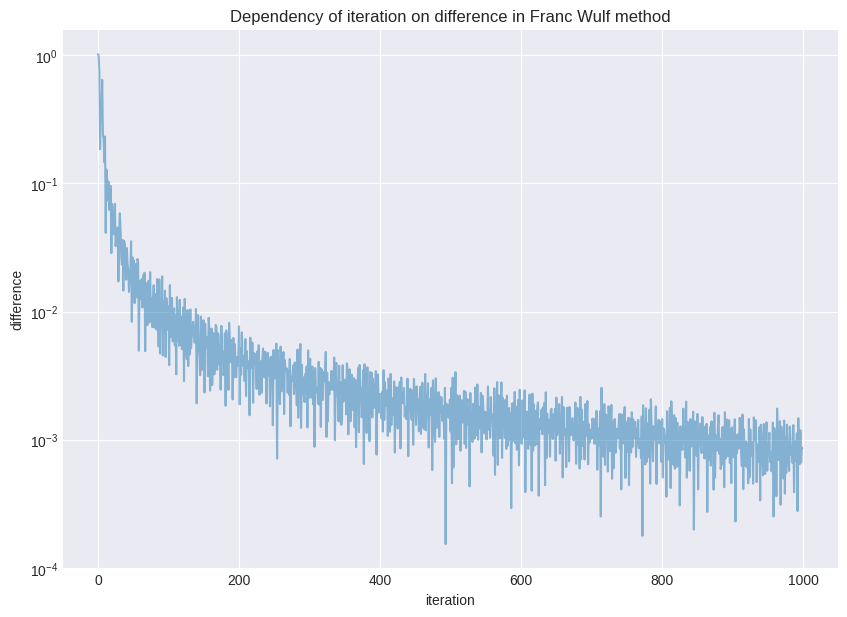

In [ ]:
w_start = w_start = tr.zeros(len(X[0]), requires_grad=True)  #Определяем стартовую точку
w_start = w_start.to(tr.float64)
K = 10**3
sp = Franc_Wulf(f, nabla_f, w_start, X_train_tr, y_train_tr, X_test_tr, 5)
difs = sp[1]
x = sp[0]
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
plt.plot(iterations, difs, markersize = 5, alpha=0.5)
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in Franc Wulf method")
plt.legend()

Видим, что алгоритм сходится и за 1000 итераций сошелся до точности примерно $10^{-4}$.

Вывидите решение, полученный с помощью метода Франк-Вульфа. Что необычного увидели? Для большей наглядности можете воспользоваться методом Нестерова из прошлого задания и решить с помощью него безусловную задачу (на $\mathbb{R}^d$) без регуляризатора. Сделайте вывод.

In [ ]:
sp[0]

tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00, -3.0458e-01,  0.0000e+00,  0.0000e+00, -9.9725e-01,
         0.0000e+00,  0.0000e+00,  2.0917e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -6.9790e-05,  0.0000e+00,
         1.3858e-03, -7.4781e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  5.9820e-05, -2.8672e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

Видим огромное количество нулей, в конечной точке сходимости алгоритма. Это наталкивает на мысль о том, что такое количество нулей тут не с проста и можно найти некую зависимость между числом итераций/точностью и количеством нулей, что мы и сделаем в дальнейшем.

__в). $\triangle$ (7 баллов)__ В прошлом задании мы, используя полученное решения задачи оптимизации, предсказывали ответы на тестовой выборке. Напомним суть: исходная задача регрессии является задачой машинного обучения и с помощью линейной модели $g$ можно предсказывать значения меток $y$. Пусть у нас есть сэмпл $x_i$, ответ модели для этого сэмпла есть $g(w^*, x^i)$. Тогда предсказывающее правило можно сформулировать следующим довольно естественным образом:
$$
y_i =
\begin{cases}
1, & g(w^*, x^i) \geq 0,
\\
-1, & g(w^*, x^i) < 0.
\end{cases}
$$
Cделав предсказания на тестовой выборке $X_{test}$, можно сравните результат с реальными метками $y_{test}$. Количество правильно угаданных меток есть точность/accuracy модели.

Посмотрите какую дает модель обученная с помощью метода Франк-Вульфа. Варьируйте $R = 5, 10, 20, 50, 100, 1000$. Постройте три графика: 1) точность итоговой модели от $R$, 2) количество ненулевых компонент в итоговом решении метода Франк-Вульфа от $R$, 3) точность от количества ненулевых компонент в итоговом решении. Сделайте вывод

In [ ]:
Rs = [5, 10, 20, 50, 100, 1000]
accuracies = []
not_nulls = []
K = 10**4
for R in Rs:
  sp = Franc_Wulf(f, nabla_f, w_start, X_train_tr, y_train_tr, X_test_tr, R, K)
  preds = sp[2]
  x = sp[0]
  preds = tr.sign(preds)
  accuracies.append(skl.metrics.accuracy_score(preds.detach().to().numpy(), y_test))
  not_nulls.append(np.count_nonzero(x.detach().to().numpy()))

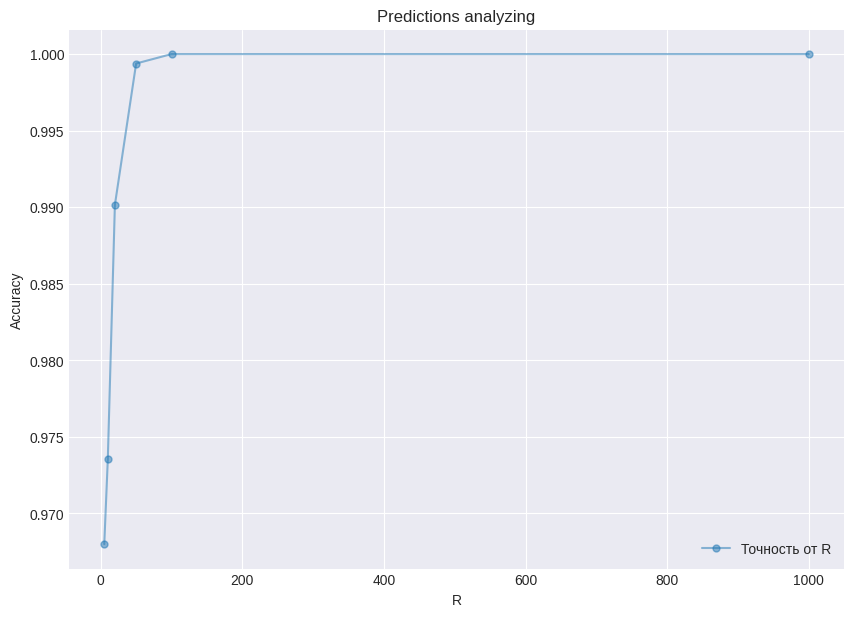

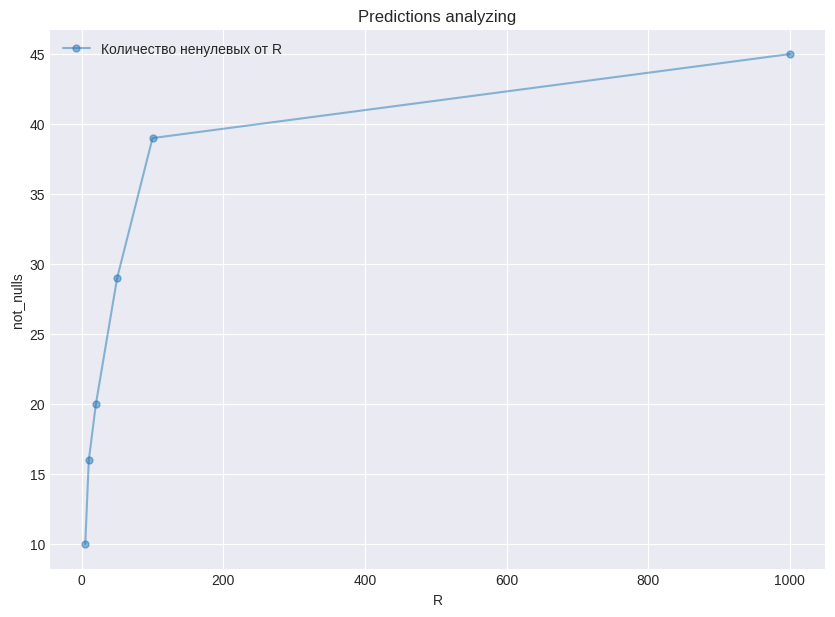

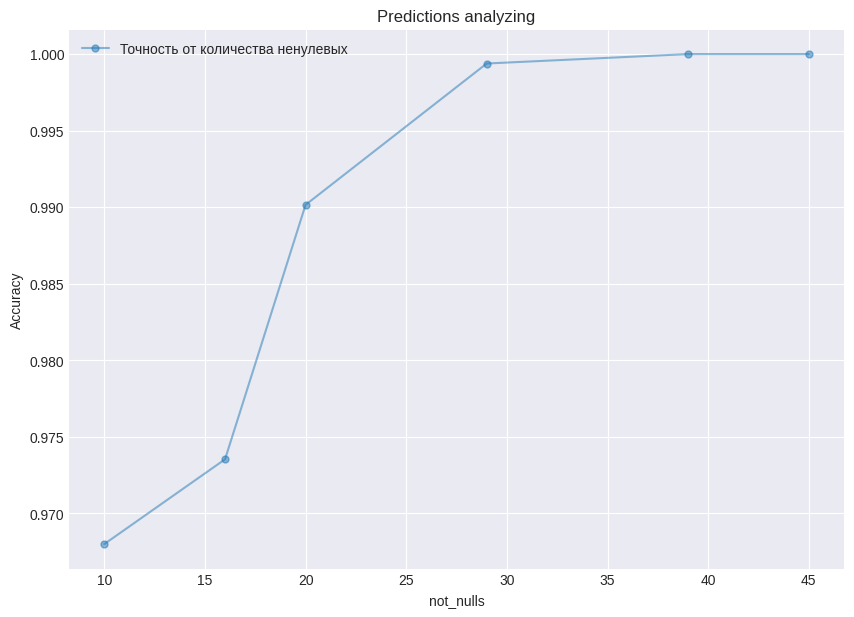

In [ ]:
plt.figure(figsize = (10, 7))
plt.plot(Rs, accuracies, markersize = 5, alpha=0.5, marker='o', label='Точность от R')
plt.xlabel("R")
plt.ylabel("Accuracy")
plt.title("Predictions analyzing")
plt.legend()
plt.figure(figsize = (10, 7))
plt.plot(Rs, not_nulls, markersize = 5, alpha=0.5, marker='o', label='Количество ненулевых от R')
plt.xlabel("R")
plt.ylabel("not_nulls")
plt.title("Predictions analyzing")
plt.legend()
plt.figure(figsize = (10, 7))
plt.plot(not_nulls, accuracies, markersize = 5, alpha=0.5, marker='o', label='Точность от количества ненулевых')
plt.xlabel("not_nulls")
plt.ylabel("Accuracy")
plt.title("Predictions analyzing")
plt.legend()

Ну и вот какие зависимости мы получили:
- С ростом R точность предсказания растет.
- С ростом R растет и количество ненулевых элементов в последней точке сходимости алгоритма
- С ростом количества ненулевых элементов в последней точке сходимости алгоритмы растет и точность.
Теперь мы выяснили, откуда у нас столько нулей и как они влияют на итоговое решение задачи оптимизации, проведя анализ по предсказаниям.

__г). $\triangle$ (15 баллов)__ Нашу задачу можнно решать и с помощью метода градиентного спуска с евклидовой проекцией. Для этого нужно уметь делать проекцию на $\ell_1$-шар. Найдите способ сделать проекцию в Интернете, достаточно загуглить: "projection onto l1 ball". Изложите здесь суть найденнного подхода (приложите ссылку откуда берете подход) и реализуйте его в коде.

Я брал решение, описанное в данной презентации: https://angms.science/doc/CVX/Proj_l1.pdf.<br>
В нем автор утверждает, что решением $proj(y|X) = \displaystyle{argmin_{x ∈ X}} \frac{1}{2}||x - y||_2^2$. Доказывает он этот факт привычными нам методами, находит Лагранжиан и выписывает условия ККТ.<br>
$L(x, λ) = \frac{1}{2}||x-y||_2^2 + λ(||x||_1 - 1) = \frac{1}{2}||x - y||_2^2 + λ||x||_1 - λ = \displaystyle{\sum_{i=1}^d (\frac{1}{2}(x_i - y_i)^2 + λ|x_i|) - λ}$.<br>
Далее мы считаем производные для условия ККТ:<br>
$d(\frac{1}{2}(x_i - y_i)^2 + λ|x_i|) = d(\frac{1}{2}(x_i - y_i)^2) + d(λ|x_i|) = \frac{d}{dx} \frac{1}{2}(x_i - y_i)^2 + λd|x_i| = x_i - y_i + λsign(x_i)$.
<br>
Теперь выпишем условия ККТ:<br>
$\begin{equation*}
 \begin{cases}
   λ \geq 0 \\
   ∇L = 0 \\
   ||x||_1 - R \leq 0 \\
   λ(||x||_1 - R) = 0
 \end{cases}
\end{equation*}$<br>
Из второго условия получаем, что $y_i = x_i + λsign(x_i)$. Учитывая это и первое условие, получаем, что либо $x_i, y_i < 0$, либо $x_i, y_i > 0$. Отсюда получаем переписанные условия ККТ:<br>
$\begin{equation*}
 \begin{cases}
   λ = 0 \text{ или } λ > 0 \\
   x_i = sign(y_i) ⋅ (|y_i| - λ)_+ \\
   ||x||_1 \leq R \\
   λ = 0 \text{ или } ||x||_1 = R
 \end{cases}
\end{equation*}$<br>
Далее автор рассматривает несколько случаев.
- Если λ = 0, то $x_i = y_i$, что означает $||y||_1 \leq R$.
- Если λ > 0, то $||x||_1 = R$. То есть мы можем просуммировав второе условие системы по всем i и получим R! Получаем: $\displaystyle{\sum_{i=1}^d(|y_i| - λ)_+ = R}$. А это выражение уже подходит для поиска $λ^*$.<br>
В итоге получаем, находим $λ^*$, и, используя его, находим каждую координату x:<br>
$\begin{equation*}
 x_i =
 \begin{cases}
   y_i + λ^*, y_i < -λ^* \\
   0, -λ^*\leq y_i \leq λ^* \\
   y_i - λ^*, y_i > λ^*
 \end{cases}
\end{equation*}$<br>
Теперь дело за малым - написать код.


Решите задачу оптимизации на обучающей выборке с помощью градиентного спуска с евклидовой проекцией. Сравните на графиках сходимость градиентного спуска и метода Франк-Вульфа: 1) значение критерия от номера итерации, 2) значение критерия от времени. Сделайте вывод.

In [ ]:
def criteria(xk, X, y, R): #Наш критерий
  grad = tr.func.grad(f)(xk, X, y).data
  ind = tr.argmax(tr.abs(grad))
  e = []
  for i in range(len(xk)):
    if (tr.tensor(i) == ind): e.append(R)
    else: e.append(0)
  e = tr.tensor(e).to(tr.float64)
  second = -tr.sign(grad[ind]) * e
  return grad @ (xk - second)

def make_BP(x, R):
  points = {}
  points_out = []
  for i in x:
    i = i.detach().to().numpy()
    point = np.absolute(i)
    if (point not in points):
      points.setdefault(point, 0)
    points[point] += (1 / R)
    if (point not in points_out):
      points_out.append(point)
  return (points, points_out)

def find_lambda(points, x, coefs, R):
  left_point = 0
  right_point = coefs[points[0]] * (points[0] - points[1])
  first = coefs[points[0]] * points[0]
  coeficent = coefs[points[0]]
  for i in range(1, len(points) - 1):
    if (left_point <= 1 and right_point >= 1):
      return (first - 1) / coeficent
    left_point = right_point
    right_point += coefs[points[i]] * (points[i] - points[i + 1])
    coeficent += coefs[points[i]]
    first += coefs[points[i]] * points[i]
  coeficent += coefs[points[-1]]
  first += coefs[points[-1]] * points[-1]
  return (first - 1) / coeficent


def projection_method(f, nabla_f, x_0, gamma_k, X, y, X_prob, R, K=10**3):
  difs = []
  times = []
  time1 = time.time()
  for k in range(K):
    difs.append(criteria(x_0, X, y, R).detach().to().numpy())
    grad = tr.func.grad(f)(x_0, X, y).data
    coefs, points = make_BP(x_0, R)
    points.sort()
    points = points[::-1]
    x_0 = x_0 - gamma_k * grad
    if (tr.sum(tr.abs(x_0)) <= R):
       pass
    else:
      lamda = find_lambda(points, x_0, coefs, R)
      for i in range(len(x_0)):
        if (x_0[i] < -tr.tensor(lamda)):
          x_0[i] = x_0[i] + lamda
        elif (x_0[i] >= -tr.tensor(lamda) and x_0[i] <= tr.tensor(lamda)):
          x_0[i] = 0
        else:
          x_0[i] = x_0[i] - lamda
    times.append(time.time() - time1)
  return (x_0, difs, times)


L = (1000 / (3996 * len(y_train)) * np.linalg.norm(X_train) ** 2)  #Определяем константу Липшеца
gamma = 1 / (13 * L)
w_start = w_start = tr.zeros(len(X[0]), requires_grad=True)  #Определяем стартовую точку
w_start = w_start.to(tr.float64)
K = 10**4
sp = projection_method(f, nabla_f, w_start, gamma, X_train_tr, y_train_tr, X_test_tr, 5, K)
difs = sp[1]
times = sp[2]
sp = Franc_Wulf(f, nabla_f, w_start, X_train_tr, y_train_tr, X_test_tr, 5, K)
difs1 = sp[1]
times1 = sp[3]

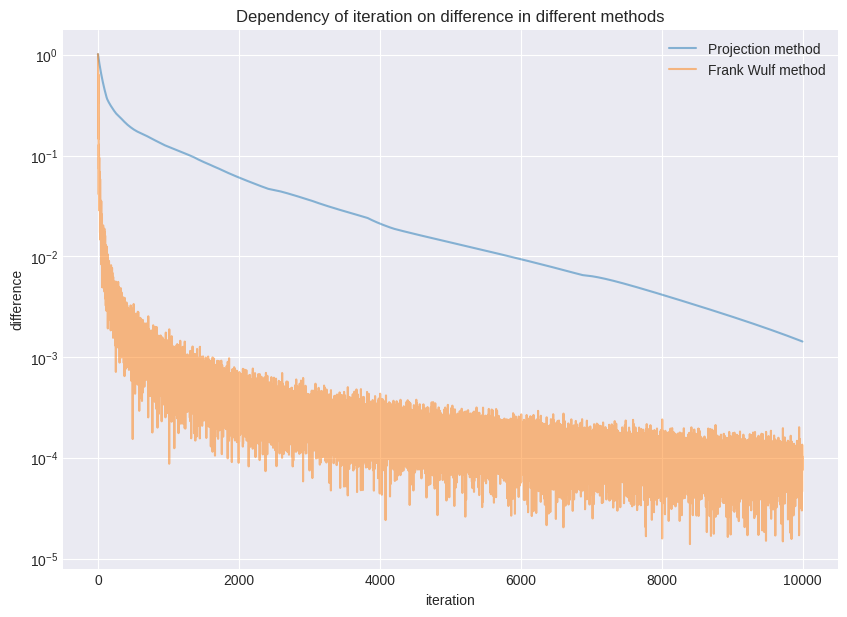

In [ ]:
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
plt.plot(iterations, difs, markersize = 5, alpha=0.5, label='Projection method')
plt.plot(iterations, difs1, markersize = 5, alpha=0.5, label='Frank Wulf method')
plt.xlabel("iteration")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of iteration on difference in different methods")
plt.legend()

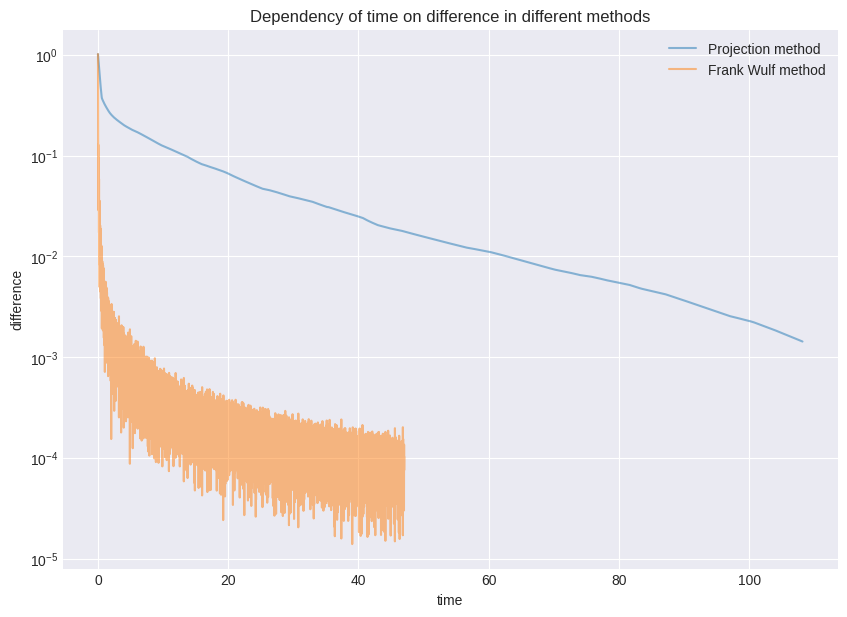

In [ ]:
plt.figure(figsize = (10, 7))
iterations = [i for i in range(K)]
plt.plot(times, difs, markersize = 5, alpha=0.5, label='Projection method')
plt.plot(times1, difs1, markersize = 5, alpha=0.5, label='Frank Wulf method')
plt.xlabel("time")
plt.ylabel("difference")
plt.yscale('log')
plt.title("Dependency of time on difference in different methods")
plt.legend()

Исходя из этих графиков, можно сделать вывод, что за 10000 итераций алгоритм Франка-Вульфа сошелся лучше и при этом более, чем в 2 раза быстрее дошел до итоговой точности, примерно $10^{-4}$, в то время, как градиентный спуск с методом проекции сошелся чуть меньше, чем до точности $10^{-3}$.

### Часть 2. Сопряженность. Двойственность. ККТ

__Задача 1. (15 балла)__ Для каждой из следующих функций $f$ вычислите сопряженную функцию $f^*$:

__а). (4 балла)__ $f: \mathbb{R}^d_+ \to \mathbb{R}$, где $f(x) = - \left(\prod_{i=1}^d x_i\right)^{1/d}$, а $\mathbb{R}^d_+$ - векторы с неотрицательными компонентами.

- Рассотрим $y_k > 0$. Возьмем $x_k = t, x_i = 1, i \neq k$ => $x^ty - f(x) = ty_k + \displaystyle{\sum_{i \neq k} y_i} - t^\frac{1}{d}$ -> ∞ при t-> ∞.
- Рассмотрим $y ≼ 0$ и $∏_i(-y_i))^\frac{1}{d} < \frac{1}{d}$. Тогда возьмем $x_i = -\frac{t}{y_i}$. Тогда получим $x^Ty - f(x) = -tn - t(∏_i(-\frac{1}{y_i}))^\frac{1}{d} → ∞$, если t → ∞.
-  Рассмотрим $y \succeq 0$ и $∏_i(-y_i))^\frac{1}{d} \geq \frac{1}{d}, x ≽ 0$.Тогда $\frac{x^Ty}{d} \geq (∏_i (-y_ix_i))^\frac{1}{d} \geq \frac{1}{d}(∏_i x_i)^\frac{1}{d}$, т.к. $x_ty \geq f(x), x_i = -\frac{1}{y_i} ⇒ f^*(y) = 0$. - Ответ.


__б). (5 баллов)__ $f: \mathbb{R}^d \to \mathbb{R}$, где $f(x) = \max_{i=1,\dots, d}\{x_i\}$.

По определению сопряженной функции: $f^*(y) = \displaystyle{\sup_{x∈\mathbb{R^d}}} (⟨x, y⟩ - \displaystyle{\max_{i=\overline{1, d}} x_i}) = \displaystyle{\sup_{x∈\mathbb{R^d}}} (x^Ty - \displaystyle{\max_{i=\overline{1, d}} x_i})$.<br>
Теперь будем рассматривать разные случае, как это делалось в методичке. Замечание: 1 воспринимается, как единичный вектор.
- Если какао-то $y_k  < 0$, тогда $x_i = 0 ∀i \neq k,  x_k = -t$ <br>
Тогда получаем $x^Ty - \displaystyle{\max_{i=\overline{1, d}} x_i} = -ty_k → +∞, t → +∞$
- Теперь пусть y ≽ 0 и $1^Ty < 1$, тогда x = -t1.<br>
Подставляем и получаем: $-t1^Ty + t = t(1 - 1^Ty) → +∞$, t → +∞<br>
- Теперь пусть y ≽ 0 и $1^Ty < 1$, тогда x = t1.<br>
Подставляем и получаем: $t1^Ty + t = t(1^Ty - 1) → +∞$, t → -∞<br>
- И остался последний случай, в котором у нас особенности не будет: y ≽ 0 и $1^Ty = 1$.<br>
Распишем $x^Ty = \displaystyle{\sum_{i=1}^d x_iy_i ≤ \max_{i=\overline{1, d}} x_i\sum_{i=1}^d y_i = \max_{i=\overline{1, d}} x_i \cdot 1^Ty = \max_{i=\overline{1, d}} x_i}$.<br>
Получаем: $\displaystyle{\sup_{x∈\mathbb{R^d}} (x^Ty - \max_{i=\overline{1, d}} x_i}$. Он достигается (по прошлому выводу) для x = 0.

Ответ: Сопряженная задача $f^*(y) = 0, domf^* = \{y ∈ \mathbb{R^d}, где y ≽ 0, 1^Ty = 1\}$.

__в). (6 баллов)__ $f: \mathbb{S}^d_{++} \to \mathbb{R}$, где $f(X) = \text{trace}(X^{-1})$ и $\mathbb{S}^d_{++}$ - положительно определенные матрицы.

Опять расписываем по определению: $f^*(Y) = \displaystyle{\sup_{X∈\mathbb{S^d_{++}}} Tr(XY - X^{-1})}.$ Теперь предположим, что $Y∈\mathbb{S^d_{++}}$, чтобы применить спектральное разложение, а именно $Y = VΛV^T$.<br>
Без ограничения общности считаем, что $λ_1 = λ_{min}$, Возьмем $X = V \cdot diag(s, 1, ..., 1)V^T$. Тогда $Tr(XY - X^{-1}) = λ_1s + \displaystyle{\sum_{i=2}^d} λ_i - \frac{1}{s} - d + 1 → ∞, s → ∞$, а значит $Y \preceq 0$. Теперь найдем супремум: $∇Tr(XY - X^{-1}) = ⟨Y, dX⟩ + ⟨X^{-1}dXX^{-1}, E⟩ = ⟨Y, dX⟩ + ⟨X^{-2}, dX⟩ = ⟨X^{-2} + Y, dX⟩$, а значит $X = (-Y)^{-\frac{1}{2}}$.<br>
Теперь подставим в определение и получим: $f^*(Y) = -2Tr(-Y)^\frac{1}{2}$.
<br>
Тогда ответ: $f^*(Y) = -2Tr(-Y)^\frac{1}{2}, domf^* = -\mathbb{S^d_{++}}$.

__Задача 2. (4 балла)__ Построите двойственную задачу для следующей задачи оптимизации:
\begin{align*}
        \min_{x} \ -\sum\limits_{i=1}^m \log (b_i - a_i^Tx)
\end{align*}
с областью определения $\{x \in \mathbb{R}^d \ | \ a_i^Tx < b_i \ \forall i = 1\ldots m\}$.

_Hint:_ Сначала введите дополнительные переменные $y_i$ и ограничения $y_i = b_i - a_i^Tx$.

Пусть $y_i = b_i - a_i^Tx$. Подставляя в исходную задачу, получаем:
$\begin{align*}
        &\min_{x} \ -\sum\limits_{i=1}^m \log y_i \\
        &\text{s.t } y = b - Ax
\end{align*}$, где $A ∈ \mathbb{R^{m×d}}$.<br>
Выписываем Лагранжиан (λ присутствовать не будут, так как у нас только равенство в ограничениях): $L(x, y, ν) = -\displaystyle{\sum_{i=1}^{m}\log y_i + ν^T(y - b + Ax)}$.<br>
$g(ν) = \displaystyle{\inf_{x, y} -(\sum_{i=1}^m \log y_i - ν(y - b + Ax)) = \inf_{x, y} -(\sum_{i=1}^m \log y_i} - ν^Ty + ν^T -ν^TAx) = \inf_{x, y} -(\sum_{i=1}^m \log y_i - ⟨ν,y⟩ + ⟨ν, b⟩ - ⟨A^Tν,x⟩)$.<br>
Теперь опять рассмотрим случаи: Если $A^Tν \neq 0$, то $g(ν) = -∞$. Вспомним, что $y ≻ 0$ - из области определения. Отсюда при $ν \preceq 0 ⇒ g(ν) = -∞$, а если $ν ≻ 0$, то $inf⟨ν, y⟩ = m$, когда $y_i = \frac{1}{ν_i}$.<br>
Отсюда уже несложно получить двойственную функцию: $f^*(y) = \displaystyle{\max_ν(\sum_{i=1}^m \log \nu_i} - b^Tν + m)$, s.t. $A^Tν = 0, ν ≻ 0$ - Ответ.

__Задача 3. (16 баллов)__
Рассмотрим задачу следующего вида: \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &x_i \in \{0, 1\}, \ \forall i = 1, \ldots, d.
     \end{align*}
     Эта задачу довольно трудно решать, поэтому есть две релаксации, которые помогают построить нижнюю оценку на оптимальное значение исходной задачи.
     Рассмотрим следующие две задачи оптимизации, которые схожи с начальной:
     \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &0 \leq x_i \leq 1, \ \forall i = 1, \ldots, d
     \end{align*}
     и
     \begin{align*}
         \min_{x} \ &c^Tx\\
         \text{s.t. } &Ax \preceq b,\\
         &x_i(1 - x_i) = 0, \ \forall i = 1, \ldots, d.
     \end{align*}
     Первая задача называется LP-релаксацией исходной задачи, и, как следует из ее записи, она дает нижнюю оценку на наше исходное оптимальное значение, а вторая задача является прямой перезаписью исходной задачи.


__а). (6 баллов)__ Выпишите двойственные задачи к LP-релаксации и ко второй задаче.

- Посчитаем Лагранжиан: $L(x, λ, ν_1, ν_2) = c^Tx + λ^T(Ax - b) - ν_1^Tx + ν_2^T(x - 1) = (c + A^Tλ - ν_1 + ν_2)^Tx - λ^Tb - ν_21,$, тогда $g(λ, ν_1, ν_2) = -∞$, если $(c + A^Tλ - ν_1 + ν_2) \neq 0$, иначе: $-b^Tλ - 1^Tν_2$.<br>
Отсюда получаем двойственную задачу:
$\displaystyle{\max_{λ, ν_1, ν_2} (-b^Tλ - 1^Tν_2)}$, s.t. $c + A^Tλ - ν_1 + ν_2 = 0, λ, ν_1, ν_2 ≽ 0$.
- Сделаем то же самое для второй задачи: $L(x, λ, ν) = c^Tx + λ^T(Ax - b) - \displaystyle{\sum_{i=1}^d ν_ix_i^2 + \sum_{i=1}^d ν_ix_i} = c^Tx + λ^T(Ax - b) - x^Tdiag(ν)x + ν^Tx = (c + A^Tλ + ν)^Tx -x^Tdiag(ν)x - λ^Tb$.<br>
Сначала заметим, что если хотя бы одно из $ν_i > 0$, то мы можем устремить соответствующую ей координату $x_i$ к бесконечности и, очевидно, получим g(λ, ν) = -∞.<br>
$∇L(x, λ, ν) = c + A^Tλ - 2diag(ν)x + ν = 0$, а значит $x_i = \frac{1}{2ν_i} ⋅ (c + A^Tλ + ν)_i$. Теперь можем записать функцию g: $g(λ, ν) = -∞$, если $ν ≻ 0$, иначе: $\frac{1}{4}\displaystyle{\sum_{i=1}^d} \frac{(c + A^Tλ + ν)_i^2}{ν_i} - b^Tλ$.<br>
Отсюда получаем следующую функцию: $\begin{equation*}
g_1(λ, ν) =
 \begin{cases}
   -∞, &∃ i: ν_i = 0 \text{ and } (c + A^Tλ + ν)_i \neq 0 \\
   ∑_{i=1}^{d}\frac{(c + A^Tλ + ν)_i^2}{ν_i}, &ν ≼ 0 \text{ and } ν_i = 0 ⟹ (c + A^Tλ + ν)_i = 0\\
   -∞, &∃ i : ν_i > 0
 \end{cases}
\end{equation*}$
<br>
По факту мы доопределили функцию в некоторых особых точках, где она была неопределенна.<br>
Тогда двойственная задача: $\displaystyle{\max_{λ, ν} \frac{1}{4} g_1(λ, ν) - b^Tλ}$, s.t. $ν ≼ 0, λ ≽ 0$.

__б). $\triangle$ (10 баллов)__ Двойственная задача ко второй задаче называется Лагранжевой релаксацией. Как следствие, она тоже дает нижнюю оценку на оптимальное значение исходной задачи. Покажите, что нижние оценки, которые вытекают из LP-релаксации и Лагранжевой релаксации, совпадают.

Теперь чуть поменяем вторую двойственную задачу, а именно зафиксируем λ и разделим выражение в числителе на слагаемые. А именно: $(c + A^Tλ + ν)_i = c_i + a_i^Tλ + ν_i$, $a_i$ - i-ый столбец матрицы A.<br>
А теперь рассмотрим два случая: (учитываем, что $ν_i \leq 0$)<br>
- $c_i + a_i^Tλ \leq 0$, то выражение под суммой в $g_1(λ, ν)$ максимально при $ν_i = (c_i + a_i^Tλ)$. Оно равно $4(c_i + a_i^Tλ)$.
- $c_i + a_i^Tλ \geq 0$, тогда то же самое выражение максимально при $ν_i = -(c_i + a_i^Tλ)$. Оно равно 0.

Тогда можем переписать сумму: $\displaystyle{\sum_{i=1}^d \frac{(c + A^Tλ + ν)_i^2}{ν_i} = 4\sum_{i=1}^d min(0, c_i + a_i^Tλ)}$.<br> Отсюда мы получаем такую задачу оптимизации: $\displaystyle{\max_λ (1^T ⋅ min(0, c + A^Tλ) -b^Tλ)}$, s.t. $λ ≽ 0$.<br>
Теперь сделаем примерно то же самое и с первой двойственной задачей: $\displaystyle{\max_{λ, ν_2}} -(b^Tλ + 1^Tν_2)$, s.t. $c + A^Tλ + ν_2 ≽ 0, λ ≽ 0, ν_2 ≽ 0$.<br>
Опять фиксируем λ и, учитывая условия задачи, получаем, что ∀i $-ν_{2_{i}} \leq min(0, c_i + a_i^Tλ)$. Нам надо максимизировать $-1^Tν_2$, надо, чтобы $-ν_{2_{i}} = -min(0, c_i + a_i^Tλ)$ и отсюда уже можем получить задачу оптимизации:<br>
$\displaystyle{\max_{λ} (1^T ⋅ min(0, c + A^Tλ) - b^Tλ)}$, s.t. $λ ≽ 0$.<br>

Видим, что после преобразований задачи фактически совпадают.


__Задача 4. $\triangle$ (8 баллов)__  

Рассмотрим следующую функцию $f: \mathbb{R}^d \to \mathbb{R}$:
$$f(x) = \sum\limits_{i=1}^r x_{[i]},$$
где $r$ - число от $1$ до $d$ и $x_{[1]} \geq \ldots \geq x_{[d]}$. Другими словами, это функция равна сумме $r$ наибольших компонент вектора $x$.

Покажите, что $f(x)$ равняется оптимальному значению следующей задачи оптимизации:
    \begin{align*}
        \max_{y \in \mathbb{R}^d} \ &x^Ty\\
        \text{s.t. }&0 \leq y \leq 1.\\
        &\text{1}^Ty = r.
    \end{align*}

Если мы упорядочим (или предположим, что они уже упорядочены) по неубыванию, то есть $x_1 \leq x_2 \leq ... \leq x_d$, то получаем, что $x^Ty \leq x_d(1^Ty) = x_dr$ - из условий задачи. Что и требовалось.

Постройте двойственную задачу к задаче из предыдущего пункта (изменив задачу максимизации на задачу минимизации).

Для начала изменим задачу:<br>
\begin{align*}
        \min_{y \in \mathbb{R}^d} \ &-x^Ty\\
        \text{s.t. }&0 \leq y \leq 1.\\
        &\text{1}^Ty = r.
    \end{align*}
Посчитаем Лагранжиан: $L(x, λ, ν_1, ν_2) = -x^Ty - λ^Ty + ν_1^T(y - 1) + ν_2(1^Ty - r) = (-x -λ + ν_1 + ν_21)y - 1^Tν_1 - ν_2r$.<br>
Теперь запишем функцию g: $g(λ, ν_1, ν_2) = -1^Tν_1 - ν_2r$, если $-x - λ + ν_1 + ν_21 = 0$, иначе: -∞.<br>
Теперь можем записать двойственную задачу: $\displaystyle{\max_{y∈\mathbb{R^d}}} -(1^Tν_1 + rν_2)$, s.t. $-λ + ν_1 + ν_21 = x, λ ≽ 0, ν_1 ≽ 0$. Но при этом мы можем заметить, что само λ не участвует в максимизирующемся выражении, а значит мы можем убрать его из условий.

__Задача 5. (4 балла)__
Рассмотрим следующую задачу минимизации:
\begin{align*}
    \min_{x \in \mathbb{R}^d} \ &\|Ax - b\|_2^2\\
    \text{s.t. } &Gx = h,
\end{align*}
где $A \in \mathbb{R}^{m \times d}$, $\text{rank } A = d$ и $G \in \mathbb{R}^{n \times d}$, $\text{rank }  G = n$. Выпишите ККТ для этой задачи, и найдите оптимальные значения $x^*$ и $\nu^*$ прямых и двойственных переменных соответственно.

Будем пользоваться условием ККТ:<br>
- $G^Tν^* + 2A^T(Ax^* - b) = 0$
- $Gx^* = h$

Из первого уравнения $x^* = (A^TA)^{-1}(A^Tb - \frac{1}{2}G^Tν^*)$. Теперь подставляем в другое уравнение: $-\frac{1}{2}G(A^TA)^{-1}G^Tν^* + G(A^TA)^{-1}A^Tb = h$, отсюда нам надо найти $v^*$.<br>
$v^* = -2G^{-T}(A^TA)G^{-1}h + 2G^{-T}(A^TA)G^{-1}G(A^TA)^{-1}A^Tb = 2G^{-T}(-(A^TA)G^{-1}h + A^Tb)$.<br>
Теперь получаем $x^*$: $x^* = (A^TA)^{-1}(A^Tb - A^Tb + (A^TA)G^{-1}h) = G^{-1}h$.<br>
Ответ: $x^* = G^{-1}h, v^* 2G^{-T}(A^Tb - (A^TA)G^{-1}h)$.

__Задача 6. $\triangle$ (10 баллов)__  Рассмотрим следующую задачу оптимизации
\begin{align*}
    \min_{x} \ &f_0(x)\\
    \text{s.t. } &f_i(x) \leq 0, \ i = 1, \ldots, m,
\end{align*}
где $f_0, \ldots, f_m$ - выпуклые дифференцируемые функции.

Предположим, что $x^* \in \mathbb{R}^d$ и $\lambda^* \in \mathbb{R}^m$ удовлетворяют условиям ККТ для нашей задачи оптимизации. Выпишите условия ККТ для этой задачи и покажите, что тогда имеет место следующее неравенство:
$$\nabla f_0(x^*)^T(x - x^*) \geq 0.$$

Опять запишем условия ККТ (берем прям с лекций):
- $λ_i^* \geq 0$
- $f_i(x^*) \leq 0$
- $λ_i^* ⋅ f_i(x^*) = 0$
- $∇f_0(x^*) + \displaystyle{\sum_{i=1}^m} λ_i^*∇f_i(x^*) = 0$

Теперь пользуемся выпуклостью $f_i(x) \leq 0$. Тогда по определению выпуклость: $f_i(x) - f_i(x^*) \geq ∇f_i(x^*)^T(x - x^*)$. Тогда $f_i(x) \geq f_i(x^*) + ∇f_i(x^*)^T(x - x^*)$, для каждого i. Теперь нам надо воспользоваться другими условиями ККТ, а именно теми, что с λ. Тогда просуммируем выражение выше по $λ_i^*$.<br>
Получаем, что $\displaystyle{\sum_{i=1}^m λ_i^*(f_i(x^*) + ∇f_i(x^*)^T(x - x^*)) = \sum_{i=1}^m λ_i^*f_i(x^*) + \sum_{i=1}^m λ_i^*∇f_i(x^*)^T(x - x^*)}$. Тогда используя третье и четвертое свойства из системы, получаем, что это выражение равняется $0 - ∇f_0(x^*)^T(x - x^*)$. Также заметим, что обе части равенства с суммами $\leq 0$, в силу того, что $λ_i^* \geq 0$. Тогда $-∇f_0(x^*)^T(x - x^*) \leq 0$, а значит $∇f_0(x^*)^T(x - x^*) \geq 0$, ЧТД.

### Часть 3. $\triangle$ Игра

На лекциях мы познакомились с экстраградиентным методом и зеркальным спуском. Первый предназначен для решения седловых задач, второй - для лучшего учета "геометрии" задачи. Попробуем объединить эти две идеи и получим следующий метод:
\begin{align}
\label{eq:1}
x^{k+1/2} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^k, y^k), x\rangle + V(x,x^k))
\\
y^{k+1/2} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^k, y^k), y\rangle + V(y,y^k))
\\
\label{eq:2}
x^{k+1} &= \arg\min_{x \in \mathcal{X}} (\gamma\langle \nabla_x f(x^{k+1/2}, y^{k+1/2}), x\rangle + V(x,x^k))
\\
y^{k+1} &= \arg\min_{y \in \mathcal{Y}} (\gamma\langle - \nabla_y f(x^{k+1/2}, y^{k+1/2}), y\rangle + V(y,y^k)),
\end{align}
где $\gamma > 0$ - шаг метода.
Для краткости введем обозначения, как на лекции:
$$
z = \binom{x}{y} \quad F(z) = F(x,y) = \binom{\nabla_x f(x, y)}{- \nabla_y f(x, y)}
$$
В новых обозначениях метод выше можно переписать, как
\begin{align}
z^{k+1/2} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^k), z\rangle + V(z,z^k))
\\
z^{k+1} &= \arg\min_{z \in \mathcal{Z}} (\gamma\langle F(z^{k+1/2}), z\rangle + V(z,z^k)).
\end{align}

Пусть оператор $F$ является $L$-Липшицевым (следует из Липшицевости градиентов):
$$
\| F(z_1) - F(z_2) \|_* \leq L \| z_1 - z_2\|,
$$
а функция $f$ является выпукло-вогнутой.

__Задача 1. $\triangle$ (10 баллов)__ Попробуем доказать сходимость данного метода, для этого понадобятся доказательства экстраградиентного метода и зеркального спуска. Объясняйте переходы там, где они кажутся неочевидными.

Для начала запишем условие оптимальности для каждой из строк рассматриваемого метода (см. как мы писали условие оптимальности в случае зеркального спуска). Для первой строки метода запишите с участие произвольной точки $u \in \mathcal{Z}$:

In [ ]:
#ваше решение (Markdown)

Для второй строки метода запишите с участие произвольной точки $z \in \mathcal{Z}$:

In [ ]:
#ваше решение (Markdown)

Далее воспользуемся "равенством параллелограмма" для дивергенции Брэгмана (мы его также доказывали на лекции про зеркальный спуск) и применим его к каждому из полученных выше условий оптимальности:

In [ ]:
#ваше решение (Markdown)

Сложим два выражения:

In [ ]:
#ваше решение (Markdown)

В качестве точки $u$ подставьте некоторую точку из алгоритма ($z^k$, $z^{k+1/2}, z^{k+1}$). Подумайте, какая точка может подойти лучше (обратите внимание на доказательство экстраградиентного метода):

In [ ]:
#ваше решение (Markdown)

Проведите некоторые алгебраические преобразования с полученным неравенством, чтобы в итоге неравенство имело вид:
$\langle F(\tilde z), \tilde z - z \rangle \leq \ldots$, где $\tilde z$ - некоторая точка из алгоритма ($z^k$, $z^{k+1/2}, z^{k+1}$):

In [ ]:
#ваше решение (Markdown)

Воспользуйтесь неравенством Коши-Буняковского-Шварца, чтобы далее можно воспользоваться, тем, что оператор $F$ является $L$-Липшецевым:

In [ ]:
#ваше решение (Markdown)

А теперь воспользуйтесь $L$-Липшецевостью оператора $F$:

In [ ]:
#ваше решение (Markdown)

Вспомните, что если дивергенция Брэгмана порождена 1-сильно выпуклой функцией, то (как уже видели на лекции) $V(x,y) \geq \frac{1}{2} \| x - y\|^2$. Воспользуйтесь этим свойством, подберите шаг $\gamma$ так, что в итоге получить результат вида: $\langle F(\tilde z), \tilde z - z \rangle \leq R_k - R_{k+1}$:

In [ ]:
#ваше решение (Markdown)

Доведите доказательство до конца (смотрите доказательство экстраградиентного метода) и сформулируйте теорему о сходимости предложенного метода для выпукло-вогнутых $L$-гладких седловых задач.

In [ ]:
#ваше решение (Markdown)

__Задача 2. $\triangle$ (20 баллов)__ Рассмотрим следующую билинейную задачу на симплексах:
$$
\min_{x \in \mathcal{X}} \max_{y \in \mathcal{Y}} f(x,y) = x^T A y,
$$
где $X = \{ x \in \mathbb{R}^d \mid x_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $Y = \{ y \in \mathbb{R}^d \mid y_i \geq 0 , \sum_{i=1}^d x_i = 1\}$, $A \in \mathbb{R^{d \times d}}$.

Такую задачу часто называют матричной игрой. В этом задании будет конкретная игра "Вор и полицейский".

Пусть город представляет собой квадрат из $n \times n$ маленьких квадратиков. В каждом квадратике стоит дом и полицейская будка рядом с ним. Пусть так же известны ценность дома для вора $w_{i}$ в квадрате $i$. Каждую ночь вор выбирает, какой дом ограбить, а полицейский выбирает будку, в которой будет дежурить. Вероятность поимки вора, если вор грабит дом в квадрате $j$, а полисмен дежурит в квадрате $i$ равна:
    $$\exp(- \alpha  \cdot \text{dist}(i,j)).$$
Здесь $\alpha > 0$ - некторый параметр, т.е. вероятность уменьшается с увеличением расстояния между квадратами.
Вор хочет максимизировать свою ожидаемую прибыль:
    $$w_j \left(1 -  \exp(- \alpha \cdot \text{dist}(i,j))\right).$$
Полицейский наоборот - минимизировать.

Такую постановку можно формализовать в виде матричной игры: занумеруем все дома от $0$ до $d = n^2 - 1$, получится вектор $w \in \mathbb{R}^{d}$ стоимостей домов. В элемент $A_{ij}$ матрицы $A$ запишем:
$$A_{ij} = w_j \left(1 - \exp(- \alpha \cdot \text{dist}(i,j))\right),$$
т.е. ожидаемую прибыль вора, если он будет грабить дом с номером $j$, а полицейский дежурить в доме с номером $i$. В векторах $x$ и $y$ будут хранится вероятностные стратегии для полицийского и вора: вероятность выбрать тот или иной дом для дежурства или грабежа. Цель задания найти равновестные стратегии.

Возьмем $n = 10$. Следующий код генерирует некоторое распределение ценностей домов $w$ и матрицу $A$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
def dist(i, j, n):
    i_x = i % n
    i_y = i // n
    j_x = j % n
    j_y = j // n
    return np.linalg.norm([i_x - j_x, i_y - j_y], 2)

def game(n = 10):
    i_max = (n // 2) * (n + 1)
    w = np.array([1. / (dist(i, i_max, n) + 20) for i in range(n ** 2)])
    A = np.zeros([n ** 2, n ** 2])
    for i in range(n ** 2):
        for j in range(n ** 2):
            A[i,j] = w[j] * (1 - np.exp(- dist(i, j, n)))
    return A, w

In [ ]:
n = 10
A, w = game(n)

In [ ]:
X, Y = np.meshgrid(range(n), range(n))
X = X.ravel()
Y = Y.ravel()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X, Y, w, c = w, cmap=cm.coolwarm)
ax.set_title(f"Веса", fontsize = 10, fontweight='bold')

plt.show()

На графике выше визуализированны стоимости домов в городе: в центре самые дорогие, на окраинах бедные.

Для игровой задачи запишите явный вид метода, для которого доказывали сходимость в Задаче 1 (на лекции мы тоже работали с симплексом). Реализуйте в виде кода.

In [ ]:
#ваше решение (Code и Markdown)

Оцените константу $L$ (смотри Задачу 1) для игровой задачи. В качестве критерия используйте следующее выражение:
$$
\text{gap}(x^k, y^k) = \max_{y \in \mathcal{Y}} f(x^k, y) - \min_{x \in \mathcal{X}} f(x, y^k), \quad \text{или} \quad \text{gap}\left( \frac{1}{k} \sum_{i=0}^{k-1} x^i, \frac{1}{k}\sum_{i=0}^{k-1} y^k \right)
$$
Выпишите явный вид подсчета $\text{gap}(x^k, y^k)$ и реализуйте его (задача не зря называется билинейной).

In [ ]:
#ваше решение (Code и Markdown)

С помощью реализованного метода решите игровую задачу. Рекомендуется подбирать шаг и брать его значительно больше $\frac{1}{L}$. Постройте график сходимости: значение критерия сходимости от номера итерации.

In [ ]:
#ваше решение (Code и Markdown)

Визуализируйте решение $x^*$ и $y^*$ на карте города. В этом может помочь визуализация весов выше. Сделайте вывод. Насколько результат кажется натуральным и интепретируемым?

In [ ]:
#ваше решение (Code и Markdown)